# FastPitch and Mixer-TTS Training

Based on [this notebook](https://github.com/NVIDIA/NeMo/blob/main/tutorials/tts/FastPitch_MixerTTS_Training.ipynb).

# License

> Copyright 2022 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [1]:
"""
You can either run this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies# .
"""
BRANCH = 'main'
# # If you're using Colab and not running locally, uncomment and run this cell.
# !apt-get install sox libsndfile1 ffmpeg
# !pip install wget text-unidecode scipy==1.7.3
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

# conda create --name nemo_tts python=3.10
# conda activate nemo_tts
# conda install pip ffmpeg
# conda install -c conda-forge sox libsndfile
# pip install wget text-unidecode scipy==1.7.3
# pip install cython
# conda install -c conda-forge pynini
# python -m pip install git+'https://github.com/NVIDIA/NeMo.git@main#egg=nemo_toolkit[all]'
# conda install git-lfs
# git lfs install

In [16]:
import json
import nemo
import torch
import librosa
import numpy as np

from pathlib import Path
from tqdm.notebook import tqdm

# Introduction

### FastPitch

FastPitch is non-autoregressive model for mel-spectrogram generation based on FastSpeech, conditioned on fundamental frequency contours. For more details about model, please refer to the original [paper](https://arxiv.org/abs/2006.06873). NeMo re-implementation of FastPitch additionally uses unsupervised speech-text [aligner](https://arxiv.org/abs/2108.10447) which was originally implemented in [FastPitch 1.1](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/FastPitch).

### Mixer-TTS

Mixer-TTS is another non-autoregressive model for mel-spectrogram generation. It is structurally similar to FastPitch: duration prediction, pitch prediction, unsupervised TTS alignment framework, but the main difference is that Mixer-TTS is based on the [MLP-Mixer](https://arxiv.org/abs/2105.01601) architecture adapted for speech synthesis.

FastPitch and Mixer-TTS like most NeMo models are defined as a LightningModule, allowing for easy training via PyTorch Lightning, and parameterized by a configuration, currently defined via a yaml file and loading using Hydra.

Let's take a look using NeMo's pretrained models and how to use it to generate spectrograms.

In [3]:
from nemo.collections.tts.models.base import SpectrogramGenerator
from nemo.collections.tts.models import FastPitchModel, MixerTTSModel

from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline

[NeMo W 2023-07-11 14:39:45 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2023-07-11 14:39:45 experimental:27] Module <class 'nemo.collections.tts.models.fastpitch_ssl.FastPitchModel_SSL'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-11 14:39:45 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-11 14:39:45 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-11 14:39:45 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[Ne

In [4]:
# Let's see what pretrained models are available for FastPitch and Mixer-TTS
print("FastPitch pretrained models:")
print(FastPitchModel.list_available_models())
print("=====================================")
print("Mixer-TTS pretrained models:")
print(MixerTTSModel.list_available_models())

FastPitch pretrained models:
[PretrainedModelInfo(
	pretrained_model_name=tts_en_fastpitch,
	description=This model is trained on LJSpeech sampled at 22050Hz with and can be used to generate female English voices with an American accent. It is ARPABET-based.,
	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_fastpitch/versions/1.8.1/files/tts_en_fastpitch_align.nemo,
	class_=<class 'nemo.collections.tts.models.fastpitch.FastPitchModel'>
), PretrainedModelInfo(
	pretrained_model_name=tts_en_fastpitch_ipa,
	description=This model is trained on LJSpeech sampled at 22050Hz with and can be used to generate female English voices with an American accent. It is IPA-based.,
	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_fastpitch/versions/IPA_1.13.0/files/tts_en_fastpitch_align_ipa.nemo,
	class_=<class 'nemo.collections.tts.models.fastpitch.FastPitchModel'>
), PretrainedModelInfo(
	pretrained_model_name=tts_en_fastpitch_multispeaker,
	description=This model is

In [4]:
# We can load the pre-trained FastModel as follows
pretrained_model = "tts_en_fastpitch"
spec_gen = FastPitchModel.from_pretrained(pretrained_model)
spec_gen.eval();

[NeMo I 2023-07-11 14:39:48 cloud:58] Found existing object /home/joregan/.cache/torch/NeMo/NeMo_1.17.0rc0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo.
[NeMo I 2023-07-11 14:39:48 cloud:64] Re-using file from: /home/joregan/.cache/torch/NeMo/NeMo_1.17.0rc0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo
[NeMo I 2023-07-11 14:39:48 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-07-11 14:40:19 fastpitch:209] This checkpoint support will be dropped after r1.18.0.
[NeMo W 2023-07-11 14:40:19 experimental:27] Module <class 'nemo.collections.tts.g2p.models.i18n_ipa.IpaG2p'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-11 14:40:20 en_us_arpabet:66] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2023-07-11 14:40:20 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /ws/LJSpeech/nvidia_ljspeech_train_clean_ngc.json
      

[NeMo I 2023-07-11 14:40:20 features:287] PADDING: 1
[NeMo I 2023-07-11 14:40:22 save_restore_connector:247] Model FastPitchModel was successfully restored from /home/joregan/.cache/torch/NeMo/NeMo_1.17.0rc0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo.


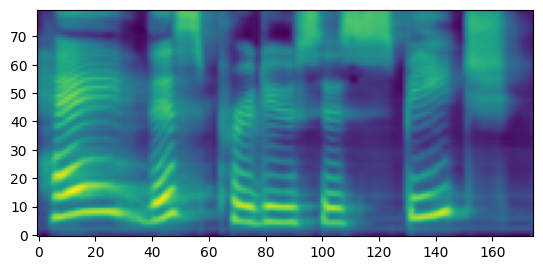

In [5]:
assert isinstance(spec_gen, SpectrogramGenerator)

if isinstance(spec_gen, FastPitchModel):
    tokens = spec_gen.parse(str_input="Hey, this produces speech!")
else:
    tokens = spec_gen.parse(text="Hey, this produces speech!")

spectrogram = spec_gen.generate_spectrogram(tokens=tokens)

# Now we can visualize the generated spectrogram
# If we want to generate speech, we have to use a vocoder in conjunction to a spectrogram generator.
# Refer to the Inference_ModelSelect notebook on how to convert spectrograms to speech.
imshow(spectrogram.cpu().detach().numpy()[0,...], origin="lower")
plt.show()

# Preprocessing

In [12]:
from nemo.collections.tts.data.dataset import TTSDataset
from nemo_text_processing.text_normalization.normalize import Normalizer

[NeMo W 2023-07-12 09:36:25 experimental:27] Module <class 'nemo.collections.tts.models.fastpitch_ssl.FastPitchModel_SSL'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-12 09:36:25 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-12 09:36:25 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-12 09:36:25 experimental:27] Module <class 'nemo.collections.tts.models.ssl_tts.SSLDisentangler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-12 09:36:25 experimental:27] Module <class 'nemo.collections.tts.models.vits.VitsModel'> is experimental, not ready for production 

In [8]:
!git clone -b original https://huggingface.co/datasets/KTH/hungarian-single-speaker-tts

fatal: destination path 'hungarian-single-speaker-tts' already exists and is not an empty directory.


In [9]:
base = !pwd

In [7]:
from pathlib import Path
BASE_PATH = Path(base[0])

NameError: name 'base' is not defined

In [ ]:
items = []
REPO_PATH = BASE_PATH / "hungarian-single-speaker-tts"
TRANSCRIPT = REPO_PATH / "transcript.txt"
with open(str(TRANSCRIPT)) as inf:
    for line in inf.readlines():
        parts = line.split("|")
        filepath = REPO_PATH / parts[0]
        text = parts[2]
        duration = parts[3]
        items.append({
            "audio_filepath": str(filepath),
            "duration": float(duration),
            "text": text
        })

In [20]:
# https://github.com/NVIDIA/NeMo/blob/main/scripts/dataset_processing/tts/thorsten_neutral/get_data.py
import random
import json
def save_json(json_file, dict_list):
    # logging.info(f"Saving JSON split to {json_file}.")
    with open(json_file, "w") as f:
        for d in dict_list:
            f.write(json.dumps(d) + "\n")

def create_splits(entries, val_size=100, test_size=100, seed_for_ds_split=100):
    random.Random(seed_for_ds_split).shuffle(entries)
    train_size = len(entries) - val_size - test_size
    if train_size <= 0:
        raise ValueError("Not enough data for the train split.")

    # logging.info("Preparing JSON train/val/test splits is complete.")
    train, val, test = (
        entries[:train_size],
        entries[train_size : train_size + val_size],
        entries[train_size + val_size :],
    )

    return train, val, test

In [17]:
train, val, test = create_splits(items)

In [21]:
save_json("manifest_train.json", train)
save_json("manifest_test.json", test)
save_json("manifest_val.json", val)

In [ ]:
!wget https://raw.githubusercontent.com/CUNY-CL/wikipron/master/data/scrape/tsv/hun_latn_narrow.tsv

### FastPitch

Now that we looked at the FastPitch model, let's see how to prepare all data for training it. 

Firstly, let's download all necessary training scripts and configs.

In [11]:
BRANCH='main'
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/fastpitch.py

# !mkdir -p conf && cd conf \
# && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/fastpitch_align_v1.05.yaml \
# && cd ..

--2023-03-24 15:04:15--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/tts/fastpitch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1365 (1.3K) [text/plain]
Saving to: ‘fastpitch.py’

fastpitch.py        100%[===================>]   1.33K  --.-KB/s    in 0s      

2023-03-24 15:04:15 (82.8 MB/s) - ‘fastpitch.py’ saved [1365/1365]

--2023-03-24 15:04:16--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/tts/conf/fastpitch_align_v1.05.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6725 (6.6K) [tex

In [ ]:
!wget https://raw.githubusercontent.com/CUNY-CL/wikipron-modeling/master/tsv/hun_phonetic_train.tsv
!wget https://raw.githubusercontent.com/CUNY-CL/wikipron-modeling/master/tsv/hun_phonetic_test.tsv
!wget https://raw.githubusercontent.com/CUNY-CL/wikipron-modeling/master/tsv/hun_phonetic_dev.tsv

In [13]:
pronunciations = []
with open("hun_phonetic_train.tsv") as phon:
    for line in phon.readlines():
        word, pron = line.strip().split("\t")
        pronunciations.append(pron)

In [ ]:
from tokenizers import Tokenizer, trainers
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import CharDelimiterSplit

tokenizer = Tokenizer(BPE()) 
tokenizer.pre_tokenizer = CharDelimiterSplit(' ')

trainer = trainers.BpeTrainer(special_tokens=["[UNK]", "<s>", "</s>"], show_progress=True)
tokenizer.train_from_iterator(pronunciations, trainer=trainer)

In [16]:
!mkdir tokeniser
tokenizer.save('./tokeniser/tokenizer.json')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Turns out the trainer for NeMo can't accept a huggingface tokeniser, needs sentencepiece instead.

In [ ]:
!cat hun_phonetic_train.tsv |awk -F'\t' '{print $NF}' > hun_phonetic_train.txt
!conda install sentencepiece
# HF tokeniser came up with 91, minus 3 special tokens
!spm_train --input=hun_phonetic_train.txt --model_prefix=hun --vocab_size=88 --character_coverage=1.0 --model_type=bpe --split_by_whitespace=true

`split_by_whitespace` is pretty useless, but it doesn't merge separate pieces.

In [ ]:
!cat hun_phonetic_train.tsv |awk -F'\t' '{print $NF}'|tr -d ' ' > hun_phonetic_train_nows.txt
!spm_train --input=hun_phonetic_train_nows.txt --model_prefix=hun_nows --vocab_size=88 --character_coverage=1.0 --model_type=bpe --split_by_whitespace=true

In [8]:
hu_HU = (
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z', 'Ä', 'Á', 'É', 'Í',
    'Ó', 'Ö', 'Ő', 'Ú', 'Ü', 'Ű'
)

In [7]:
# nemo/collections/common/tokenizers/text_to_speech/ipa_lexicon.py
def get_grapheme_character_set(case: str = "upper") -> str:
    charset_str_origin = ''.join(hu_HU)
    if case == "upper":
        # Directly call .upper() will convert 'ß' into 'SS' according to https://bugs.python.org/issue30810.
        charset_str = charset_str_origin.replace('ß', 'ẞ').upper()
    elif case == "lower":
        charset_str = charset_str_origin.lower()
    elif case == "mixed":
        charset_str = charset_str_origin.replace('ß', 'ẞ').upper() + charset_str_origin.lower()
    else:
        raise ValueError(
            f"Grapheme character case not found: '{case}'."
        )
    return charset_str

In [9]:
from nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers import BaseCharsTokenizer
from nemo.collections.common.tokenizers.text_to_speech.ipa_lexicon import get_ipa_punctuation_list
from nemo.collections.common.tokenizers.text_to_speech.tokenizer_utils import any_locale_text_preprocessing

class HungarianCharsTokenizer(BaseCharsTokenizer):

    _LOCALE = "hu-HU"
    _PUNCT_LIST = get_ipa_punctuation_list("de-DE")
    _CHARSET_STR = get_grapheme_character_set(case="mixed")

    def __init__(
        self,
        chars=_CHARSET_STR,
        punct=True,
        apostrophe=True,
        add_blank_at=None,
        pad_with_space=False,
        non_default_punct_list=_PUNCT_LIST,
        text_preprocessing_func=any_locale_text_preprocessing,
    ):
        """Hungarian grapheme-based tokenizer.
        Args:
            punct: Whether to reserve grapheme for basic punctuation or not.
            apostrophe: Whether to use apostrophe or not.
            add_blank_at: Add blank to labels in the specified order ("last") or after tokens (any non None),
             if None then no blank in labels.
            pad_with_space: Whether to pad text with spaces at the beginning and at the end or not.
            non_default_punct_list: List of punctuation marks which will be used instead default.
            text_preprocessing_func: Text preprocessing function for correct execution of the tokenizer. By default, it
            would keep any word unchanged.
        """
        super().__init__(
            chars=chars,
            punct=punct,
            apostrophe=apostrophe,
            add_blank_at=add_blank_at,
            pad_with_space=pad_with_space,
            non_default_punct_list=non_default_punct_list,
            text_preprocessing_func=text_preprocessing_func,
        )


In [10]:
%%writefile conf/fastpitch_align.yaml
name: "fastpitch_align"

manifest_filepath: "manifest_train.json"
sup_data_path: "sup_data"
sup_data_types: [ "align_prior_matrix", "pitch" ]

dataset:
  _target_: nemo.collections.tts.data.dataset.TTSDataset
  manifest_filepath: ${manifest_filepath}
  sample_rate: 22050
  sup_data_path: ${sup_data_path}
  sup_data_types: ${sup_data_types}
  n_fft: 1024
  win_length: 1024
  hop_length: 256
  window: "hann"
  n_mels: 80
  lowfreq: 0
  highfreq: null
  max_duration: null
  min_duration: 0.1
  ignore_file: null
  trim: true
  trim_top_db: 50
  trim_frame_length: ${dataset.win_length}
  trim_hop_length: ${dataset.hop_length}
  pitch_fmin: 65.40639132514966
  pitch_fmax: 2093.004522404789

  text_normalizer:
    _target_: nemo_text_processing.text_normalization.normalize.Normalizer
    lang: hu
    input_case: cased

  text_normalizer_call_kwargs:
    verbose: false
    punct_pre_process: true
    punct_post_process: true

  text_tokenizer:
    _target_: nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.GermanCharsTokenizer
    punct: true
    apostrophe: true
    pad_with_space: true

Overwriting conf/fastpitch_align.yaml


TTS text preprocessing pipeline consists of two stages: text normalization and text tokenization. Both of them can be handled by `nemo.collections.tts.data.dataset.TTSDataset` for training.  

Our current example dataset is in English, so let's use `nemo_text_processing.text_normalization.normalize.Normalizer` for normalization which supports English (and many other languages!) and `nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.EnglishCharsTokenizer`. So, our model will receive grapheme representation of text (graphemes) as input.

In [13]:
# Text normalizer
text_normalizer = Normalizer(
    lang="hu",
    input_case="cased",
)

text_normalizer_call_kwargs = {
    "punct_pre_process": False,
    "punct_post_process": False
}

# Text tokenizer
text_tokenizer = HungarianCharsTokenizer()

Get Hungarian data

In [ ]:
!git clone -b original https://huggingface.co/datasets/KTH/hungarian-single-speaker-tts

To accelerate and stabilize our training, we also need to extract pitch for every audio, estimate pitch statistics (mean and std) and pre-calculate alignment prior matrices for alignment framework. To do this, all we need to do is iterate over our data one time.

In the below method the arguments are as follows:
- `sup_data_path` — path to the folder which contains supplementary data. If the supplementary data or the folder does not already exists then it will be created.

- `sup_data_types` — types of supplementary data to be provided to the model.

- `text_tokenizer` — text tokenizer object that we already created.

- `text_normalizer` — text normalizer object that we already created.

- `text_normalizer_call_kwargs` — dictionary of arguments to be used in calling the text normalizer that we already created.

In [14]:
def pre_calculate_supplementary_data(sup_data_path, sup_data_types, text_tokenizer, text_normalizer, text_normalizer_call_kwargs):
    # init train and val dataloaders
    stages = ["train", "val"]
    stage2dl = {}
    for stage in stages:
        ds = TTSDataset(
            manifest_filepath=f"manifest_{stage}.json",
            sample_rate=22050,
            sup_data_path=sup_data_path,
            sup_data_types=sup_data_types,
            n_fft=1024,
            win_length=1024,
            hop_length=256,
            window="hann",
            n_mels=80,
            lowfreq=0,
            highfreq=8000,
            text_tokenizer=text_tokenizer,
            text_normalizer=text_normalizer,
            text_normalizer_call_kwargs=text_normalizer_call_kwargs

        ) 
        stage2dl[stage] = torch.utils.data.DataLoader(ds, batch_size=1, collate_fn=ds._collate_fn, num_workers=1)

    # iteration over dataloaders
    pitch_mean, pitch_std, pitch_min, pitch_max = None, None, None, None
    for stage, dl in stage2dl.items():
        pitch_list = []
        for batch in tqdm(dl, total=len(dl)):
            tokens, tokens_lengths, audios, audio_lengths, attn_prior, pitches, pitches_lengths = batch
            pitch = pitches.squeeze(0)
            pitch_list.append(pitch[pitch != 0])

        if stage == "train":
            pitch_tensor = torch.cat(pitch_list)
            pitch_mean, pitch_std = pitch_tensor.mean().item(), pitch_tensor.std().item()
            pitch_min, pitch_max = pitch_tensor.min().item(), pitch_tensor.max().item()
            
    return pitch_mean, pitch_std, pitch_min, pitch_max

In [17]:
fastpitch_sup_data_path = "fastpitch_sup_data_folder"
sup_data_types = ["align_prior_matrix", "pitch"]

pitch_mean, pitch_std, pitch_min, pitch_max = pre_calculate_supplementary_data(
    fastpitch_sup_data_path, sup_data_types, text_tokenizer, text_normalizer, text_normalizer_call_kwargs
)

[NeMo I 2023-07-12 09:54:58 dataset:227] Loading dataset from manifest_train.json.


4315it [03:45, 19.17it/s]

[NeMo I 2023-07-12 09:58:43 dataset:265] Loaded dataset with 4315 files.
[NeMo I 2023-07-12 09:58:43 dataset:267] Dataset contains 9.57 hours.
[NeMo I 2023-07-12 09:58:43 dataset:375] Pruned 0 files. Final dataset contains 4315 files
[NeMo I 2023-07-12 09:58:43 dataset:377] Pruned 0.00 hours. Final dataset contains 9.57 hours.


[NeMo I 2023-07-12 09:58:43 dataset:227] Loading dataset from manifest_val.json.


100it [00:05, 19.70it/s]

[NeMo I 2023-07-12 09:58:48 dataset:265] Loaded dataset with 100 files.
[NeMo I 2023-07-12 09:58:48 dataset:267] Dataset contains 0.22 hours.
[NeMo I 2023-07-12 09:58:48 dataset:375] Pruned 0 files. Final dataset contains 100 files
[NeMo I 2023-07-12 09:58:48 dataset:377] Pruned 0.00 hours. Final dataset contains 0.22 hours.


  0%|          | 0/4315 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
(pitch_mean, pitch_std, pitch_min, pitch_max)

(191.5050048828125, 31.038196563720703, 65.4063949584961, 1986.977294921875)

In [19]:
%%writefile conf/fastpitch_align_v1.05.yaml

name: FastPitch

train_dataset: "manifest_train.json"
validation_datasets: "manifest_val.json"
sup_data_path: "sup_data"
sup_data_types: [ "align_prior_matrix", "pitch" ]

# Default values from librosa.pyin
pitch_fmin: 65.40639132514966
pitch_fmax: 2093.004522404789

# these frame-wise values depend on pitch_fmin and pitch_fmax, you can get values
# by running `scripts/dataset_processing/tts/extract_sup_data.py`
pitch_mean: 191.5050048828125  # e.g. 212.35873413085938 for LJSpeech
pitch_std:  31.038196563720703  # e.g.  68.52806091308594 for LJSpeech

# Default values for dataset with sample_rate=22050
sample_rate: 22050
n_mel_channels: 80
n_window_size: 1024
n_window_stride: 256
n_fft: 1024
lowfreq: 0
highfreq: 8000
window: hann

phoneme_dict_path: "hun_phonetic_train.tsv"

model:
  learn_alignment: true
  bin_loss_warmup_epochs: 100

  n_speakers: 1
  max_token_duration: 75
  symbols_embedding_dim: 384
  pitch_embedding_kernel_size: 3

  pitch_fmin: ${pitch_fmin}
  pitch_fmax: ${pitch_fmax}

  pitch_mean: ${pitch_mean}
  pitch_std: ${pitch_std}

  sample_rate: ${sample_rate}
  n_mel_channels: ${n_mel_channels}
  n_window_size: ${n_window_size}
  n_window_stride: ${n_window_stride}
  n_fft: ${n_fft}
  lowfreq: ${lowfreq}
  highfreq: ${highfreq}
  window: ${window}

  text_normalizer:
    _target_: nemo_text_processing.text_normalization.normalize.Normalizer
    lang: hu
    input_case: cased

  text_normalizer_call_kwargs:
    verbose: false
    punct_pre_process: true
    punct_post_process: true

  text_tokenizer:
    _target_: nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer
    punct: true
    stresses: true
    chars: true
    apostrophe: true
    pad_with_space: true
    g2p:
      _target_: nemo.collections.tts.g2p.models.i18n_ipa.IpaG2p
      phoneme_dict: ${phoneme_dict_path}
      phoneme_probability: 0.5

  train_ds:
    dataset:
      _target_: nemo.collections.tts.data.dataset.TTSDataset
      manifest_filepath: ${train_dataset}
      sample_rate: ${model.sample_rate}
      sup_data_path: ${sup_data_path}
      sup_data_types: ${sup_data_types}
      n_fft: ${model.n_fft}
      win_length: ${model.n_window_size}
      hop_length: ${model.n_window_stride}
      window: ${model.window}
      n_mels: ${model.n_mel_channels}
      lowfreq: ${model.lowfreq}
      highfreq: ${model.highfreq}
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: ${model.pitch_fmin}
      pitch_fmax: ${model.pitch_fmax}
      pitch_norm: true
      pitch_mean: ${model.pitch_mean}
      pitch_std: ${model.pitch_std}
      use_beta_binomial_interpolator: true

    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 32
      num_workers: 12
      pin_memory: true

  validation_ds:
    dataset:
      _target_: nemo.collections.tts.data.dataset.TTSDataset
      manifest_filepath: ${validation_datasets}
      sample_rate: ${model.sample_rate}
      sup_data_path: ${sup_data_path}
      sup_data_types: ${sup_data_types}
      n_fft: ${model.n_fft}
      win_length: ${model.n_window_size}
      hop_length: ${model.n_window_stride}
      window: ${model.window}
      n_mels: ${model.n_mel_channels}
      lowfreq: ${model.lowfreq}
      highfreq: ${model.highfreq}
      max_duration: null
      min_duration: null
      ignore_file: null
      trim: false
      pitch_fmin: ${model.pitch_fmin}
      pitch_fmax: ${model.pitch_fmax}
      pitch_norm: true
      pitch_mean: ${model.pitch_mean}
      pitch_std: ${model.pitch_std}
      use_beta_binomial_interpolator: true

    dataloader_params:
      drop_last: false
      shuffle: false
      batch_size: 32
      num_workers: 8
      pin_memory: true

  preprocessor:
    _target_: nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor
    features: ${model.n_mel_channels}
    lowfreq: ${model.lowfreq}
    highfreq: ${model.highfreq}
    n_fft: ${model.n_fft}
    n_window_size: ${model.n_window_size}
    window_size: false
    n_window_stride: ${model.n_window_stride}
    window_stride: false
    pad_to: 1
    pad_value: 0
    sample_rate: ${model.sample_rate}
    window: ${model.window}
    normalize: null
    preemph: null
    dither: 0.0
    frame_splicing: 1
    log: true
    log_zero_guard_type: add
    log_zero_guard_value: 1e-05
    mag_power: 1.0

  input_fft: #n_embed and padding_idx are added by the model
    _target_: nemo.collections.tts.modules.transformer.FFTransformerEncoder
    n_layer: 6
    n_head: 1
    d_model: ${model.symbols_embedding_dim}
    d_head: 64
    d_inner: 1536
    kernel_size: 3
    dropout: 0.1
    dropatt: 0.1
    dropemb: 0.0
    d_embed: ${model.symbols_embedding_dim}

  output_fft:
    _target_: nemo.collections.tts.modules.transformer.FFTransformerDecoder
    n_layer: 6
    n_head: 1
    d_model: ${model.symbols_embedding_dim}
    d_head: 64
    d_inner: 1536
    kernel_size: 3
    dropout: 0.1
    dropatt: 0.1
    dropemb: 0.0

  alignment_module:
    _target_: nemo.collections.tts.modules.aligner.AlignmentEncoder
    n_text_channels: ${model.symbols_embedding_dim}

  duration_predictor:
    _target_: nemo.collections.tts.modules.fastpitch.TemporalPredictor
    input_size: ${model.symbols_embedding_dim}
    kernel_size: 3
    filter_size: 256
    dropout: 0.1
    n_layers: 2

  pitch_predictor:
    _target_: nemo.collections.tts.modules.fastpitch.TemporalPredictor
    input_size: ${model.symbols_embedding_dim}
    kernel_size: 3
    filter_size: 256
    dropout: 0.1
    n_layers: 2

  optim:
    name: adamw
    lr: 1e-3
    betas: [0.9, 0.999]
    weight_decay: 1e-6

    sched:
      name: NoamAnnealing
      warmup_steps: 1000
      last_epoch: -1
      d_model: 1  # Disable scaling based on model dim

trainer:
  num_nodes: 1
  devices: 1
  accelerator: gpu
  strategy: ddp
  precision: 16
  max_epochs: 1000
  accumulate_grad_batches: 1
  gradient_clip_val: 1000.0
  enable_checkpointing: False # Provided by exp_manager
  logger: false # Provided by exp_manager
  log_every_n_steps: 100
  check_val_every_n_epoch: 5
  benchmark: false

exp_manager:
  exp_dir: null
  name: ${name}
  create_tensorboard_logger: true
  create_checkpoint_callback: true
  checkpoint_callback_params:
    monitor: val_loss
  resume_if_exists: false
  resume_ignore_no_checkpoint: false

Overwriting conf/fastpitch_align_v1.05.yaml


### Mixer-TTS

Now, let's see how to prepare data for training Mixer-TTS. 

Firstly, let's download all necessary training scripts and configs.

In [ ]:
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/mixer_tts.py

!mkdir -p conf && cd conf \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/mixer-tts.yaml \
&& cd ..

In the FastPitch pipeline we used a char-based tokenizer, but in the Mixer-TTS training pipeline we would like to demonstrate a phoneme-based tokenizer `nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.EnglishPhonemesTokenizer`. Unlike char-based tokenizer, `EnglishPhonemesTokenizer` needs a phoneme dictionary and a heteronym dictionary. We will be using the same `nemo_text_processing.text_normalization.normalize.Normalizer` for normalizing the text as used in the FastPitch example.

In [ ]:
# Text normalizer
text_normalizer = Normalizer(
    lang="en", 
    input_case="cased", 
)

text_normalizer_call_kwargs = {
    "punct_pre_process": True,
    "punct_post_process": True
}

# Grapheme-to-phoneme module
g2p = EnglishG2p(
    phoneme_dict="tts_dataset_files/cmudict-0.7b_nv22.10",
    heteronyms="tts_dataset_files/heteronyms-052722"
)

# Text tokenizer
text_tokenizer = EnglishPhonemesTokenizer(
    punct=True,
    stresses=True,
    chars=True,
    apostrophe=True,
    pad_with_space=True,
    g2p=g2p,
)

Just like in FastPitch we will need to extract pitch for every audio, estimate pitch statistics (mean and std) and pre-calculate alignment prior matrices for alignment framework.

In [ ]:
mixer_tts_sup_data_path = "mixer_tts_sup_data_folder"
sup_data_types = ["align_prior_matrix", "pitch"]

pitch_mean, pitch_std, pitch_min, pitch_max = pre_calculate_supplementary_data(
    mixer_tts_sup_data_path, sup_data_types, text_tokenizer, text_normalizer, text_normalizer_call_kwargs
)

# Training

### FastPitch

Now we are ready for training our model! Let's try to train FastPitch.

*NOTE: The sample data is not enough data to properly train a FastPitch. This will not result in a trained FastPitch and is used to just as example.*

In [20]:
!(python fastpitch.py --config-name=fastpitch_align_v1.05.yaml \
  sample_rate=16000 \
  sup_data_types="['align_prior_matrix', 'pitch']" \
  sup_data_path={fastpitch_sup_data_path} \
  pitch_mean={pitch_mean} \
  pitch_std={pitch_std} \
  pitch_fmin={pitch_min} \
  pitch_fmax={pitch_max} \
  ~model.text_tokenizer \
  +model.text_tokenizer._target_=nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.BaseCharsTokenizer \
  +trainer.max_steps=100 ~trainer.max_epochs \
  trainer.check_val_every_n_epoch=25 \
  +trainer.max_epochs=5 \
  model.train_ds.dataloader_params.batch_size=24 \
  model.validation_ds.dataloader_params.batch_size=24 \
  exp_manager.exp_dir=./fastpitch_log_dir \
  model.n_speakers=1 trainer.devices=1 trainer.strategy=null \
)

[NeMo W 2023-07-12 10:08:10 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2023-07-12 10:08:11 experimental:27] Module <class 'nemo.collections.tts.models.fastpitch_ssl.FastPitchModel_SSL'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-12 10:08:11 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-12 10:08:11 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-12 10:08:12 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[Ne

Let's look at some of the options in the training command:

- *`~model.text_tokenizer`* — remove default text tokenizer. The default tokenizer in the `fastpitch_align_v1.05.yaml` is `nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.EnglishPhonemesTokenizer`, but we want to use `nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.EnglishCharsTokenizer`.

- *`+model.text_tokenizer._target_`* — add `nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.EnglishCharsTokenizer` as text tokenizer class.

### Mixer-TTS

Now we are ready for training our model! Let's try to train Mixer-TTS.

*NOTE: The sample data is not enough data to properly train a Mixer-TTS. This will not result in a trained Mixer-TTS and is used to just as example.*

In [ ]:
!python mixer_tts.py sample_rate=16000 \
train_dataset=tests/data/asr/an4_train.json \
validation_datasets=tests/data/asr/an4_val.json \
sup_data_types="['align_prior_matrix', 'pitch']" \
sup_data_path={mixer_tts_sup_data_path} \
phoneme_dict_path=tts_dataset_files/cmudict-0.7b_nv22.10 \
heteronyms_path=tts_dataset_files/heteronyms-052722 \
pitch_mean={pitch_mean} \
pitch_std={pitch_std} \
model.train_ds.dataloader_params.batch_size=6 \
model.train_ds.dataloader_params.num_workers=0 \
model.validation_ds.dataloader_params.num_workers=0 \
trainer.max_epochs=3 \
trainer.strategy=null \
trainer.check_val_every_n_epoch=1

That's it!

In order to train FastPitch and Mixer-TTS for real purposes, it is highly recommended to obtain high quality speech data with the following properties:

* Sampling rate of 22050Hz or higher
* Single speaker
* Speech should contain a variety of speech phonemes
* Audio split into segments of 1-10 seconds
* Audio segments should not have silence at the beginning and end
* Audio segments should not contain long silences inside